A decision tree is a tree-like model used for making decisions in various fields, including machine learning, statistics, and operations research. It is a flowchart-like structure where each internal node represents a decision based on the value of a particular feature, each branch represents the outcome of that decision, and each leaf node represents the final decision or the predicted outcome.

Here's a basic explanation of how a decision tree works:

Root Node: The topmost node in the tree, representing the initial decision or the entire dataset.

Internal Nodes: These nodes represent decisions based on the values of specific features. Each internal node has branches corresponding to different possible values of the feature.

Branches: The branches represent the outcomes or possible values of the decision based on the feature at an internal node.

Leaf Nodes: The terminal nodes or leaves of the tree, which provide the final decision or the predicted outcome.

The process of decision-making involves starting at the root node, then moving down the tree based on the values of features until a leaf node is reached, which provides the final decision.

Decision trees are used in various applications, including classification and regression tasks in machine learning. They are popular because of their simplicity, interpretability, and the ability to handle both numerical and categorical data. Additionally, decision trees can be part of more complex ensemble methods, such as random forests and gradient boosting.

Here we use the Iris dataset, which is relatively simple. We will get a high accuracy, but I want to take this opportunity to break down the decision making. This is a decision tree for clustering, later we will look into regressors.

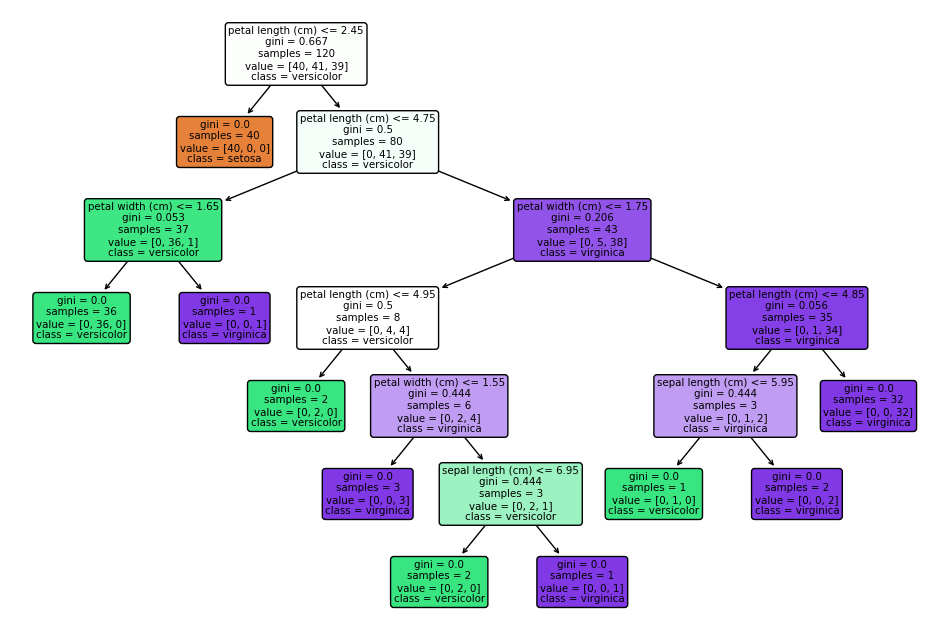

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
tree_classifier = DecisionTreeClassifier()

# Train the decision tree on the training data
tree_classifier.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_classifier, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True)
plt.show()


The Gini index measures the probability of incorrectly classifying an element randomly chosen from the set. A lower Gini index indicates a purer or less impure set, where a set is considered pure if all elements belong to the same class (Gini index is 0), and less pure if the elements are evenly distributed across classes (Gini index is close to 1).

In the context of decision trees, when selecting a feature to split on, the feature and threshold that result in the lowest Gini index for the child nodes are chosen, aiming to decrease impurity and make the resulting subsets more homogeneous. This process is used recursively to build the tree.

It's worth noting that while Gini index is a common impurity measure, other measures such as entropy (information gain) are also used in decision trees and machine learning models. Different impurity measures might be preferred depending on the specific characteristics of the data and the goals of the modeling task.

While this is a simpler data set, it is useful to bring up the explainability problem of these complex algorithms. Also known as the Black Box Effect, we do not always know exactly what the algorithms are specfically doing, but we do know the input and outcome. A novel field trending in ML is Explainable Artifical Intelligence, or Explainable Machine Learning, which aims to make ML more accessible and explainable; and often works closely with techniques such as Interactive Machine Learning and Human Feedback (i.e. RLHF).

Now that we are moving beyond a conceptual understanding of regression techniques, some of the next notebooks will break down these concepts.

GPT: "Create a decision tree from scratch, then run it on the Iris dataset."

In [4]:
import numpy as np

#Okay, our goal is to create a class which can compute a decison tree. Remember, 
#Create a class. 
class DecisionTree:
    def __init__(self, max_depth=None):
        # Constructor to initialize the DecisionTree instance
        self.max_depth = max_depth

    def fit(self, X, y):
        # Fit the decision tree on the training data
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        # Recursive function to build the decision tree
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)

        # Check termination conditions
        if len(unique_classes) == 1:
            # If all samples have the same class, create a leaf node
            return {'class': unique_classes[0]}
        if depth == self.max_depth:
            # If maximum depth is reached, create a leaf node with the most common class
            return {'class': self._most_common_class(y)}

        # Find the best split for the current node
        best_split = self._find_best_split(X, y)

        if best_split is None:
            # If no good split is found, create a leaf node with the most common class
            return {'class': self._most_common_class(y)}

        feature_index, threshold = best_split

        # Split the data based on the best split
        left_indices = X[:, feature_index] <= threshold
        right_indices = ~left_indices

        # Recursively build the left and right subtrees
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        # Create a node for the current split
        return {'feature_index': feature_index,
                'threshold': threshold,
                'left': left_subtree,
                'right': right_subtree}

    def _find_best_split(self, X, y):
        # Find the best split for the current node using the Gini impurity
        num_samples, num_features = X.shape
        if num_samples <= 1:
            return None

        unique_classes = np.unique(y)
        if len(unique_classes) == 1:
            return None

        best_gini = float('inf')
        best_split = None

        # Iterate over each feature and its unique values to find the best split
        for feature_index in range(num_features):
            feature_values = np.unique(X[:, feature_index])
            for threshold in feature_values:
                left_indices = X[:, feature_index] <= threshold
                right_indices = ~left_indices

                gini = self._calculate_gini(y[left_indices], y[right_indices])

                if gini < best_gini:
                    best_gini = gini
                    best_split = (feature_index, threshold)

        return best_split

    def _calculate_gini(self, left_y, right_y):
        # Calculate the Gini impurity for a split
        left_size = len(left_y)
        right_size = len(right_y)
        total_size = left_size + right_size

        gini_left = 1.0 - sum([(np.sum(left_y == c) / left_size) ** 2 for c in np.unique(left_y)])
        gini_right = 1.0 - sum([(np.sum(right_y == c) / right_size) ** 2 for c in np.unique(right_y)])

        gini = (left_size / total_size) * gini_left + (right_size / total_size) * gini_right

        return gini

    def _most_common_class(self, y):
        # Find the most common class in a set of labels
        return np.bincount(y).argmax()

    def predict(self, X):
        # Make predictions for a set of samples using the trained decision tree
        return np.array([self._predict_tree(x, self.tree) for x in X])

    def _predict_tree(self, x, tree):
        # Recursive function to make predictions for a single sample
        if 'class' in tree:
            # If the current node is a leaf, return the predicted class
            return tree['class']
        else:
            # If the current node is an internal node, traverse the tree to the left or right
            feature_value = x[tree['feature_index']]
            branch = tree['left'] if feature_value <= tree['threshold'] else tree['right']
            return self._predict_tree(x, branch)

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the decision tree
tree = DecisionTree(max_depth=3)
tree.fit(X_train, y_train)

# Make predictions on the test set
predictions = tree.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


In the above code, we can see how decision trees are broken down into steps. In the next two code blocks, let's use this decision tree built from scratch, and compare the accuracy to the DecisionTreeClassifier from Scikit.

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Breast Cancer Wisconsin dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the decision tree
tree = DecisionTree(max_depth=5)
tree.fit(X_train, y_train)

# Make predictions on the test set
predictions = tree.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.93


In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load the Breast Cancer Wisconsin dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Classifier
tree_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)

# Fit the classifier to the training data
tree_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = tree_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.95


We can also use this concept of decision trees for regression. Lets compare the fit from a decision tree, polynomial, and linear regression.

In [25]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Load the California Housing dataset
california_housing = fetch_california_housing(as_frame=True)
X = california_housing.data
y = california_housing.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

# Decision Tree Regressor
tree_regressor = DecisionTreeRegressor(max_depth=5)
tree_regressor.fit(X_train, y_train)
tree_predictions = tree_regressor.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_predictions)
tree_r2 = r2_score(y_test, tree_predictions)
print(f"Decision Tree MSE: {tree_mse:.2f}, R-squared: {tree_r2:.2f}")

# Linear Regression
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
linear_predictions = linear_regressor.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_predictions)
linear_r2 = r2_score(y_test, linear_predictions)
print(f"Linear Regression MSE: {linear_mse:.2f}, R-squared: {linear_r2:.2f}")

# Polynomial Regression (degree=2)
poly_regressor = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_regressor.fit(X_train, y_train)
poly_predictions = poly_regressor.predict(X_test)
poly_mse = mean_squared_error(y_test, poly_predictions)
poly_r2 = r2_score(y_test, poly_predictions)
print(f"Polynomial Regression MSE: {poly_mse:.2f}, R-squared: {poly_r2:.2f}")


Decision Tree MSE: 0.47, R-squared: 0.64
Linear Regression MSE: 0.53, R-squared: 0.60
Polynomial Regression MSE: 54.28, R-squared: -39.76


Here we see that the decision performed best.

There are other decision trees such as H2o and Orange3 that are popular packages, but these require more specific environmnet setups. Now that we understand decision trees, we will look into Forests next. 

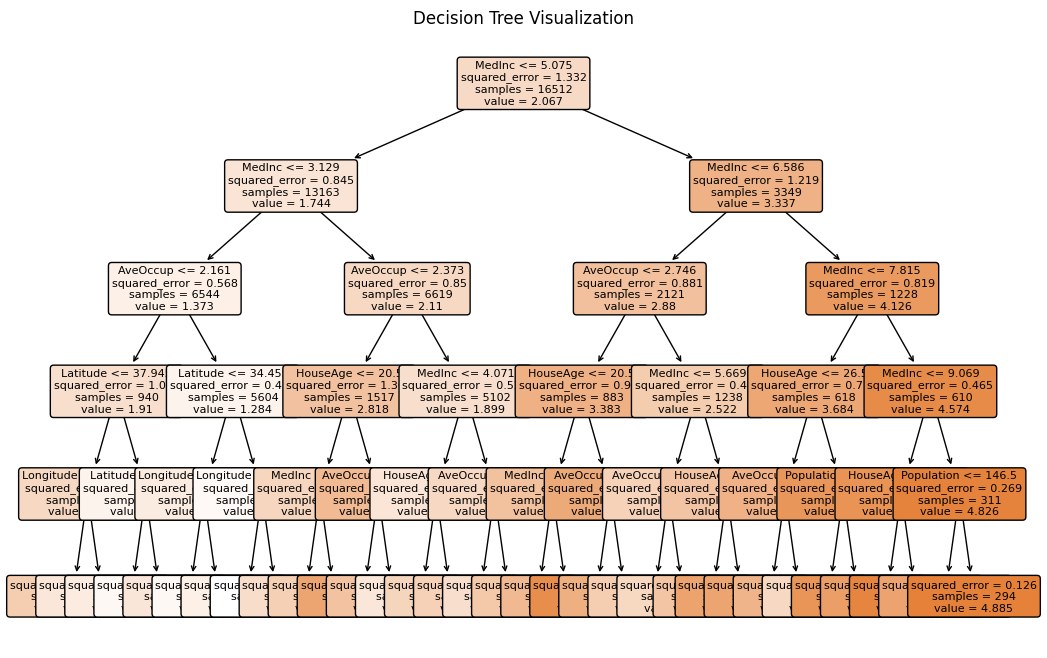

In [27]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(tree_regressor, filled=True, feature_names=X.columns, rounded=True, fontsize=8)
plt.title("Decision Tree Visualization")
plt.show()